# **DeePTB** [V2.2+] | 训练Sn的紧束缚 + SOC 案例

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ 作者: <a style="font-weight:normal" href="mailto:guqq@ustc.edu.cn">顾强强 📨 </a> </a></b></i><br/>
        日期：2025-12-20<br/>
    </p>
</div>

<p style="color:purple; font-weight:bold">DeePTB是使用深度学习构建第一性原理精度的紧束缚（TB）模型的方法，可用于加速材料的电子结构计算。目前该软件已经迭代更新至v2.2+ 版本。</p>

**本教程主要介绍DeePTB 如何在non-SOC TB的基础上训练考虑SOC的TB模型**

完成本案例你将了解 DeePTB 训练SOC的流程 

# 整体介绍

基于目前的模型训练逻辑，实现考虑SOC的模型有两个路径，
1. [**强烈推荐**] 先进行 non-soc 的 SKTB 模型训练, 然后在该模型基础上加入SOC 去拟合 DFT + SOC 的本征值数据 
2. 直接从 +soc 的Baseline 模型，直接去训练拟合 DFT + SOC 的本征值数据，训练 +SOC 的DeePTB-SK 模型。

针对两种路线进行介绍

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
# os.chdir('./examples/Sn_soc')

## 1. 数据准备
```bash
data
├── non_soc
│   ├── Sn.vasp
│   └── set.0
│       ├── eigenvalues.npy
│       ├── info.json
│       ├── kpoints.npy
│       └── xdat.traj
└── soc
    ├── Sn.vasp
    └── set.0
        ├── eigenvalues.npy
        ├── info.json
        ├── kpoints.npy
        └── xdat.traj
```


### 2.1 路线 1: 先non-SOC TB 模型训练，再＋SOC

因此部分和训练Si的模型一致，详见快速上手指南。这部分就不做详细解释，快速运行下面相应代码即可

#### 1. non-SOC TB 模型训练

In [ ]:
!dptb esk Sn_orb.json
!dptb train inputs/input_nsoc.json -i ./sktb.json -o non_soc
# 如果觉得精度不够，可以加载上一步训练模型，再运行一轮训练
# !dptb train inputs/input_nsoc.json -i non_soc/checkpoint/nnsk.best.pth -o non_soc

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

训练完毕查看能带:

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

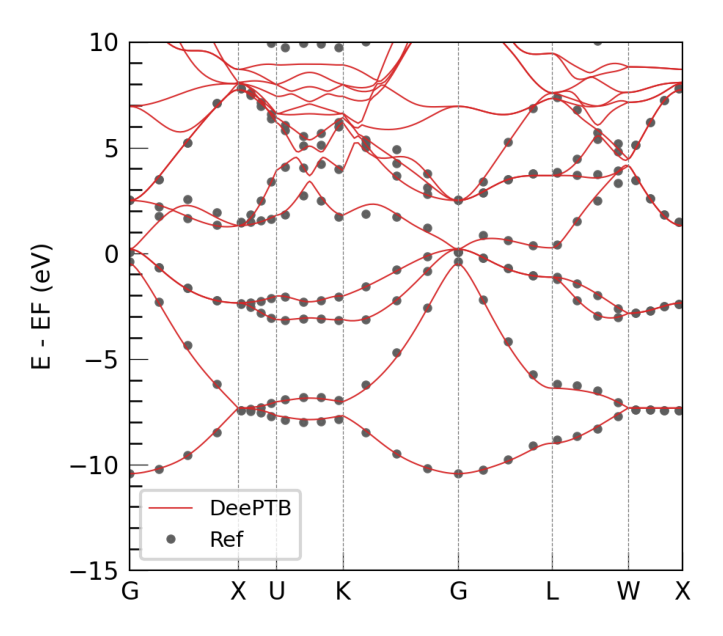

In [10]:
!dptb run band.json -i non_soc/checkpoint/nnsk.best.pth -stu ./data/non_soc/Sn.vasp -o non_soc_band

# display the band plot:
image_path = f'non_soc_band/results/band.png'

img = mpimg.imread(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

#### 2. +SOC 训练， 关键在于修改 input 

```json
"model_options": {
    "nnsk": {
        ...,
        "soc": {
            "method": "uniform_noref" or "uniform" #The same as onsite method.
            },
    }
    ...
}
"data_options": {
    "train": {
        "root": "root_path_for_dft_soc_data",
        "prefix": "prefix",
        "get_eigenvalues": true,
        "type": "DefaultDataset",
        "get_Hamiltonian": false
    }
}
```

**注意此时强烈推荐做一次freeze的训练，冻结除了SOC之外的其他参数，具体修改为：**
```json
"model_options": {
    "nnsk": {
        ...,
        "freeze": ["hopping","onsite","overlap"]
    }
    ...
}
```
**input json 文件设置之后，就可以直接加载non-soc的模型训练了。**

In [58]:
!dptb train inputs/input_soc_frz.json -i non_soc/checkpoint/nnsk.best.pth -o soc_frz

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

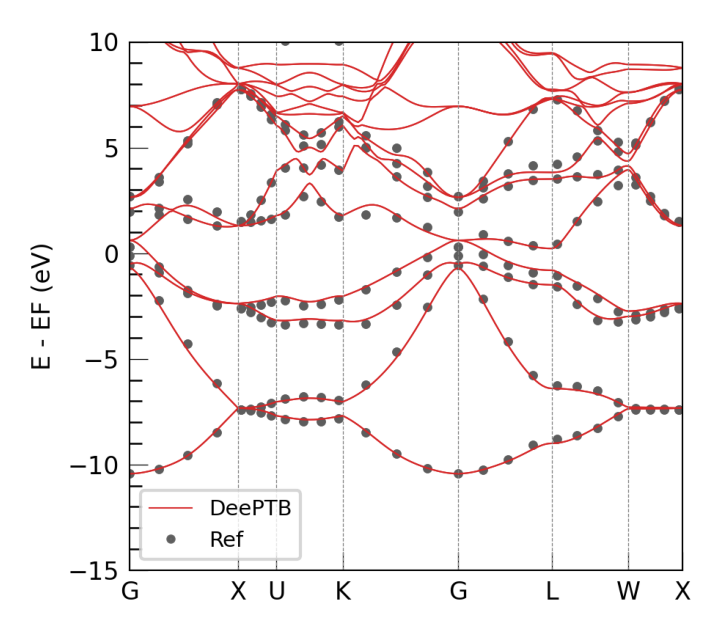

In [59]:
!dptb run band_soc.json -i soc_frz/checkpoint/nnsk.best.pth -stu ./data/non_soc/Sn.vasp -o soc_frz_band

# display the band plot:
image_path = f'soc_frz_band/results/band.png'

img = mpimg.imread(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

经过一轮freeze hopping, onsite, overlap 的训练，只有SOC的强度被训练。
此时你应该已经得到了 TB+SOC的模型。此时的模型从理论上来说才更准确。

**保证了同时在w/o SOC下的TB模型的准确**

如果你不在意上述约束。追求更高的精度，可以放开对"hopping","onsite"的冻结。
**overlap always frozen** 

```json
"model_options": {
    "nnsk": {
        ...,
        "freeze": ["overlap"]
    }
    ...
}
```

In [60]:
!dptb train inputs/input_soc.json -i soc_frz/checkpoint/nnsk.best.pth -o soc_nofz

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

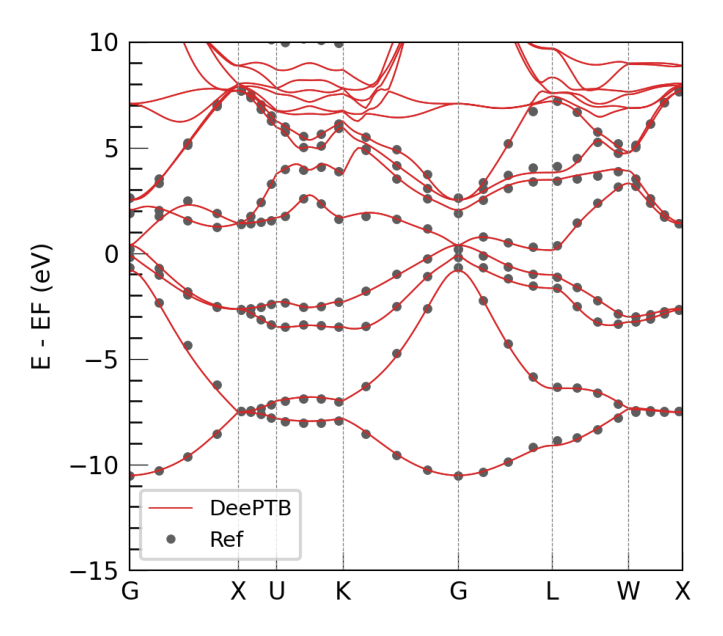

In [61]:
!dptb run band_soc.json -i soc_nofz/checkpoint/nnsk.best.pth -stu ./data/non_soc/Sn.vasp -o soc_nofz_band

# display the band plot:
image_path = f'soc_nofz_band/results/band.png'

img = mpimg.imread(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2.2 路线 2: 从 +SOC 的Baseline 模型，直接去训练拟合 DFT + SOC 的本征值数据

1. 导出+SOC的Baseline 模型
   
首先指定你需要的元素和轨道的设置，这里针对Sn体系：
```json
{
    "common_options": {
        "basis": {
            "Sn": ["s","p","d"]
        }
    }
}
```
或者
```json
{
    "common_options": {
        "basis": {
            "Sn": ["5s","5p","d*"]
        }
    }
}

以上两种配置分别对应本案例中两个文件的内容：`Sn_orb.json` 和 `Sn_orb_shell.json`

In [16]:
!dptb esk Sn_orb.json --soc

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

打开生成的 sktb.json 注意几个关键位置：
```json
"model_options": {
    "nnsk": {
        ...
        "soc": {
                "method": "uniform_noref"
            },
        ...
    }
}
...
"model_params": {
    ...
    "soc": {
            "Sn-5s-0": [
                0.0
            ],
            "Sn-5p-0": [
                0.1
            ],
            "Sn-d*-0": [
                0.1
            ]
        }
}
```
注意这里的`uniform_noref`是和前面定义轨道对应的。当轨道只是简单的 s p d 这样，那就是uniform_noref, 如果是指定了 shell 如 5s, 5p, d* 这样的轨道，那就是 uniform

在此时有可能一开始的Baseline 模型也不够准确，我们也不太方便加对freeze的命令。因此只好全部放开同时训练。

In [55]:
!dptb train inputs/input_soc.json -i sktb.json -o soc_2

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

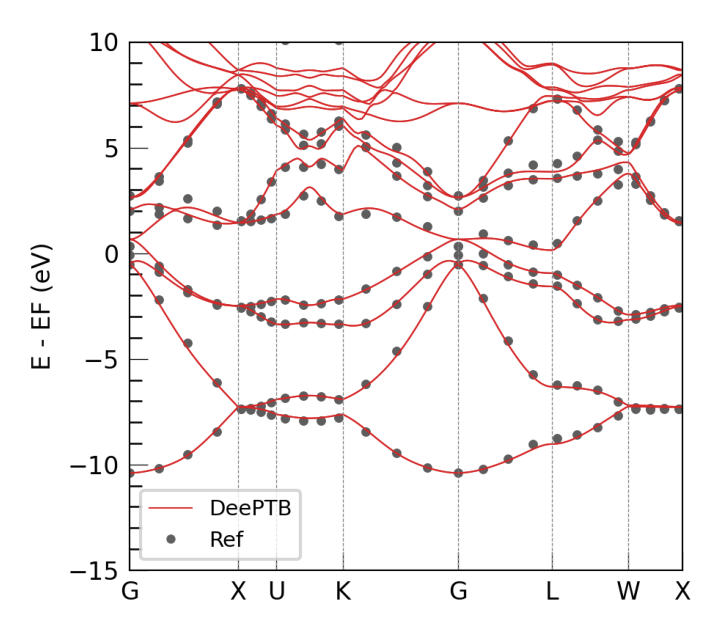

In [56]:
!dptb run band_soc.json -i soc_2/checkpoint/nnsk.best.pth -stu ./data/non_soc/Sn.vasp -o soc_band

# display the band plot:
image_path = f'soc_band/results/band.png'

img = mpimg.imread(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

可以看到此时得到的模型，是不如路线1得到的模型的。因此强烈对推荐路线 1.